In [363]:
import gurobipy as gp
from gurobipy import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import math
import itertools
from itertools import combinations
from itertools import permutations
from itertools import permutations, product
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point

## Problem: Carbon and economic cost minimization

### Parameters
- $d_{i,j}$: The distance between station $i$ and station $j$.
- $E_i$: The existing number of bikes at station $i$ before rebalancing.
- $I_i = [\lambda_i - \omega_i, \lambda_i + \omega_i]$: The ideal threshold of bikes at station $i$ after rebalancing, which is represented by a predetermined idea amount $\lambda_i$ associated with a symmetric threshold of $2\omega_i$.
- $\gamma_i$: Capacity (number of docks) of bike station $i$.
- $n$: Number of stations.
- $C$: Capacity of the truck.
- $h$: Wage for driver, dollars per bike.
- $g$: Price of Gasoline, dollars per kilometer.
- $s_{i}^+$: A binary value that indicates whether there is a bike surplus at station $i$, i.e. $s_{i}^+ = 1$ when $E_i > \lambda_i + \omega_i$, and zero otherwise.
- $s_{i}^-$: A binary value that indicates whether there is a bike shortage at station $i$, i.e. $s_{i}^- = 1$ when $E_i < \lambda_i - \omega_i$, and zero otherwise.

In [364]:
#Data importing and preprocessing
df_nodes = pd.read_excel('Cluster_1/cluster_1.5.xlsx')
#stations = [coordinates of each station]
n = df_nodes.shape[0]
stations = [[np.array(df_nodes.Latitude)[i], np.array(df_nodes.Longitude)[i]] for i in range(n)]

In [365]:
#df_nodes=df_nodes.drop([4])

In [366]:
df_nodes
print(f"Total demand for this set of nodes is: {df_nodes['Bikes in excess'].sum()}")

Total demand for this set of nodes is: -33


In [367]:
#df_nodes= df_nodes.drop(10)
#df_nodes= df_nodes.drop(5)
#df_nodes= df_nodes.drop(4)


In [368]:
df_nodes

,Station Name,No. of trip starts,No. of trip ends,Bikes in excess,Latitude,Longitude
0,Columbus Drive,31,28,-3,40.718804,-74.038817
1,Van Vorst Park,24,20,-4,40.718520,-74.047807
2,City Hall,25,22,-3,40.717783,-74.043917
3,York St & Marin Blvd,17,14,-3,40.716677,-74.042280
4,Exchange Pl,40,39,-1,40.716440,-74.034544
5,JC Medical Center,25,20,-5,40.715586,-74.049726
6,Grand St,20,15,-5,40.715062,-74.037705
7,Marin Light Rail,29,30,1,40.714613,-74.042798
8,Paulus Hook,20,19,-1,40.714164,-74.033602
9,Essex Light Rail,18,11,-7,40.712843,-74.037053


In [369]:
"""# Define indices to swap
first_pair_indices = [1, 2]  # Rows to swap
second_pair_indices = [9, 10]  # Rows to swap with

# Swap the rows using temporary storage
df_temp = df_nodes.iloc[first_pair_indices + second_pair_indices].copy()

# Reassign rows
df_nodes.iloc[first_pair_indices] = df_temp.iloc[len(first_pair_indices):].values
df_nodes.iloc[second_pair_indices] = df_temp.iloc[:len(first_pair_indices)].values"""

'# Define indices to swap\nfirst_pair_indices = [1, 2]  # Rows to swap\nsecond_pair_indices = [9, 10]  # Rows to swap with\n\n# Swap the rows using temporary storage\ndf_temp = df_nodes.iloc[first_pair_indices + second_pair_indices].copy()\n\n# Reassign rows\ndf_nodes.iloc[first_pair_indices] = df_temp.iloc[len(first_pair_indices):].values\ndf_nodes.iloc[second_pair_indices] = df_temp.iloc[:len(first_pair_indices)].values'

In [370]:
df_nodes

,Station Name,No. of trip starts,No. of trip ends,Bikes in excess,Latitude,Longitude
0,Columbus Drive,31,28,-3,40.718804,-74.038817
1,Van Vorst Park,24,20,-4,40.718520,-74.047807
2,City Hall,25,22,-3,40.717783,-74.043917
3,York St & Marin Blvd,17,14,-3,40.716677,-74.042280
4,Exchange Pl,40,39,-1,40.716440,-74.034544
5,JC Medical Center,25,20,-5,40.715586,-74.049726
6,Grand St,20,15,-5,40.715062,-74.037705
7,Marin Light Rail,29,30,1,40.714613,-74.042798
8,Paulus Hook,20,19,-1,40.714164,-74.033602
9,Essex Light Rail,18,11,-7,40.712843,-74.037053


In [371]:
#Demand
diff = np.array(df_nodes['Bikes in excess'])

In [372]:
diff

array([-3, -4, -3, -3, -1, -5, -5,  1, -1, -7, -2], dtype=int64)

In [373]:
# Calculate mean latitude and longitude for depot
mean_latitude = df_nodes['Latitude'].mean()
mean_longitude = df_nodes['Longitude'].mean()
# Create the new row as a dictionary
new_row = {
    'Station Name': 'Depot',
    'No. of trip starts': 0,
    'No. of trip ends': 0,
    'Bikes in excess': 0,
    'Latitude': mean_latitude,
    'Longitude': mean_longitude
}

# Create a DataFrame from the new row
new_row_df = pd.DataFrame([new_row])

# Concatenate the new row DataFrame with the original DataFrame, placing the new row first
df_nodes = pd.concat([new_row_df, df_nodes], ignore_index=True)

#### Make directory to save results

In [374]:
os.makedirs('Cluster_1/results_cluster1', exist_ok=True)

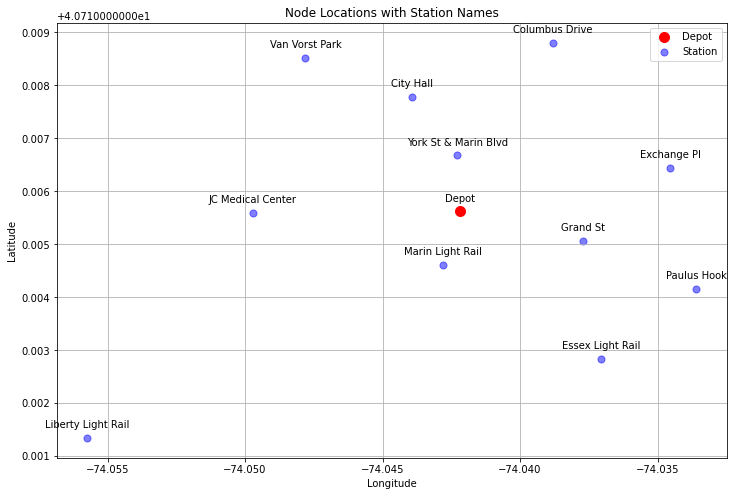

In [375]:
#Plotting the stations
plt.figure(figsize=(12, 8))

# Plot all nodes
for i, row in df_nodes.iterrows():
    if row['Station Name'] == 'Depot':  # Check if the node is a Depot
        plt.scatter(row['Longitude'], row['Latitude'], color='red', s=100, label='Depot' if 'Depot' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.scatter(row['Longitude'], row['Latitude'], color='blue', s=50, alpha=0.5, label='Station' if 'Station' not in plt.gca().get_legend_handles_labels()[1] else "")

    # Annotate each node with its station name
    plt.annotate(row['Station Name'], (row['Longitude'], row['Latitude']), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Node Locations with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.savefig('Cluster_1/results_cluster1/nodes_depot.png')
plt.show()


In [376]:
ideal_level=[]

In [377]:
rows= (df_nodes.shape[0]-1)

In [378]:
df_nodes

,Station Name,No. of trip starts,No. of trip ends,Bikes in excess,Latitude,Longitude
0,Depot,0,0,0,40.715621,-74.042180
1,Columbus Drive,31,28,-3,40.718804,-74.038817
2,Van Vorst Park,24,20,-4,40.718520,-74.047807
3,City Hall,25,22,-3,40.717783,-74.043917
4,York St & Marin Blvd,17,14,-3,40.716677,-74.042280
5,Exchange Pl,40,39,-1,40.716440,-74.034544
6,JC Medical Center,25,20,-5,40.715586,-74.049726
7,Grand St,20,15,-5,40.715062,-74.037705
8,Marin Light Rail,29,30,1,40.714613,-74.042798
9,Paulus Hook,20,19,-1,40.714164,-74.033602


In [379]:
cap=[]

In [380]:
stations

[[40.71880361715, -74.03881661250122],
 [40.71852019277083, -74.04780710466667],
 [40.71778320534079, -74.04391686793159],
 [40.71667655433856, -74.04228038533282],
 [40.71644015157092, -74.0345441003428],
 [40.71558622924017, -74.04972617564039],
 [40.71506219260593, -74.03770460188105],
 [40.7146127583203, -74.0427978857271],
 [40.71416427694101, -74.03360184187169],
 [40.7128429452931, -74.0370525100546],
 [40.71134294549493, -74.0557343385527]]

In [381]:
#It will be assumed that each station has a dock capacity of 15
#cap= np.array([15] * (n-1)) #doesn't Includes the depot station

cap=np.full((df_nodes.shape[0]-1),15)
cap= np.insert(cap,0,0)

ideal_level = np.floor(cap * 0.9) #ideal level is at 90%
ideal_level = ideal_level.astype(int)


#Existing number of bikes at stations, list of integers of length n 
#This is assumed based on the ideal level (10 bikes in this case) a station should have and the demand
diff= np.insert(diff,0,0)
E = np.floor(cap * 0.9) + diff
E = E.astype(int)

#Manhattan Distance
#@ith WGS 1984 coordinate projection 111, 1 degree = 111 KM. Could be better to calculate osmnx shortest path distance!
d_m = [[111 * abs(i[0] - j[0]) + 111 * abs(i[1] - j[1]) for i in stations] for j in stations]

threshold = 0
I = [[ideal_level[i] - threshold, ideal_level[i] + threshold] for i in range((df_nodes.shape[0]))] #doesnt considers depot


#Capacity of the truck
C = 33

#Binary values indicates surplus/shortage at staion i
s1 = [int(E[i] - I[i][1] > 0) for i in range((df_nodes.shape[0]))] #surplus
s2 = [int(I[i][0] - E[i] > 0) for i in range((df_nodes.shape[0]))] #shortage


CL= 16 * math.pow(10, -6) #Carbon trade cost ICV and EV (USD/gCO2)
co2_ICV= 243.1 #Carbon emission factor of an ICV (gCO2/km)
co2_EV= 188.1  #Carbon emission factor of an EV (gCO2/km)

cost_per_km_gasoline = 3.89 / (25 * (1.609344))
cost_per_kWh = 0.30  # Average cost of electricity per kWh in USD
consumption_rate_kWh_per_km = 0.18  # Average electric vehicle consumption in kWh per kilometer
electricity_cost_per_km = consumption_rate_kWh_per_km * cost_per_kWh
electricity_cost_per_km


fuel_ICV=  cost_per_km_gasoline #fuel cost per km. $3.89 is the average gasoline price per gallon in NY. Assuming a fuel efficiency of 25 miles per gallon. 
elec_EV= electricity_cost_per_km 


#Obj parameters: wages and costs
h = 0.875 #cost per bike-rebalanced (wage for the worker)
g = (cost_per_km_gasoline + (CL*co2_ICV))
g1= (electricity_cost_per_km + (CL*co2_EV))

In [382]:
print(g,g1)

0.10057495751212915 0.0570096


In [383]:
n

11

In [384]:
result = 16 * math.pow(10, -6)
result

1.6e-05

In [385]:
len(cap)

len(E)
len(I)
len(I)

12

In [386]:
len(s2)

12

In [387]:
parameters_df = pd.DataFrame({
    'Capacity': cap,
    'Ideal Level': I,
    'Existing_bikes': E,
    'Demand': diff,
    "Surplus_station": s1, #E[i] - I[i]
    "Shortage_station": s2  #I[i] - E[i]
})
parameters_df

,Capacity,Ideal Level,Existing_bikes,Demand,Surplus_station,Shortage_station
0,0,"[0, 0]",0,0,0,0
1,15,"[13, 13]",10,-3,0,1
2,15,"[13, 13]",9,-4,0,1
3,15,"[13, 13]",10,-3,0,1
4,15,"[13, 13]",10,-3,0,1
5,15,"[13, 13]",12,-1,0,1
6,15,"[13, 13]",8,-5,0,1
7,15,"[13, 13]",8,-5,0,1
8,15,"[13, 13]",14,1,1,0
9,15,"[13, 13]",12,-1,0,1


### Variables
- $x_{i,j}$: A binary variable that indicates the relocation truck passes through station $i$ to station $j$ if $x_{i,j} = 1$, and zero otherwise.
- $c_{i}$: The current number of bikes on the truck before arriving at station $i$.
- $d_{i}$: The number of bikes the truck drops off at station $i$.
- $p_{i}$: The number of bikes the truck picks up at station $i$.

### Dummy Variables
- $z_i$: Non-decreasing variables to ensure continuity of the route, for $i \in \{1 \dots n\}$.


### Other Notations
- $B$: The total number of bikes that are relocated.
- $D$: The total distance that the truck has traveled.
- $V$: The total number of stations visited (for record tracking purpose ONLY).

In [388]:
#Profit Maximization Model
prob = Model('BIXI')

x = prob.addVars(n, n, vtype='B', name = 'x_i,j') #BINARY: x_{i,j}
c = prob.addVars(n,lb = 0, vtype='I', name = 'current_bikes_i') #INTEGER: c_i 
d = prob.addVars(n,lb = 0, vtype='I', name = 'bikes_dropped_i') #INTEGER: d_i
p = prob.addVars(n,lb = 0, vtype='I', name = 'bikes_picked_i') #INTEGER: p_i
z = prob.addVars(n,lb = 0, name = 'z_continous')

B = prob.addVar(lb = 0, vtype='I', name = 'total_bikes_rebalanced') #INTEGER: total number of bikes rebalanced
D = prob.addVar(lb = 0, name = 'D') #INTEGER: total distance travelled by truck

#Variable to check accuracy
V = prob.addVar(lb = 0, vtype='I', name = 'total_stations_visited') #INTEGER, total number of stations visited
d_sum = prob.addVar(lb = 0, vtype='I', name = 'total_bikes_dropped_off') #INTEGER, total number of bikes dropped off
p_sum = prob.addVar(lb = 0, vtype='I', name = 'total_bikes_picked') #INTEGER, total number of bikes picked up

### Assumptions
- Routing
  - 1. Each station is visited at most once. (Routing-1)
  - 2. The truck starts at station 0 and ends at station 0. (Routing-2)
  - 3. The distance will be calcuated using Manhattan distance.
- Rebalancing
  - 1. The truck arrives at station with number of bikes equal to the toal demand of the cluster.
  - 2. The operational cost has three components, the wage for the worker, gas cost, electricity cost
 

### Variations
- fixed subpath on bike stations located near hospitals, extra cost for disinfecting during COVID-19
- Nonlinear objective

### Objective
$$\text{Minimize } \big( h * B + g * D)$$

In [389]:
obj = h*B + g*D
prob.setObjective(obj, GRB.MINIMIZE)

### Constraints - Routing

$$\begin{align}
\sum_i x_{ij} & \le 1 \hspace{0.5cm} i = \{2 \dots n\} \tag{Routing-1.1}\\
\sum_j x_{ij} & \le 1 \hspace{0.5cm} j = \{2 \dots n\} \tag{Routing-1.2}\\
\sum_i x_{ij} & = \sum_i x_{ji} \hspace{0.5cm} \tag{Routing-1.3}\\
\sum_i x_{ii} & = 0 \hspace{0.5cm} \tag{Routing-1.4}\\
\sum_i x_{i1} & = 1 \tag{Routing-2.1}\\
\sum_j x_{1j} & = 1 \tag{Routing-2.2}\\
\sum_{i,j} x_{ij} d_{ij} & = D  \tag{Total distance}\\
z_j & \ge z_i + 1 - 1996(1 - x_{ij}) \tag{Continuity of route}\\
\end{align}$$

In [390]:
n-1

10

In [391]:
n

11

In [392]:
#---Routing---

#Routing-1.1
for j in range(n):
    prob.addConstr(quicksum(x[i,j] for i in range(n)) <= 1)
    
#Routing-1.2    
for i in range(n):
    prob.addConstr(quicksum(x[i,j] for j in range(n)) <= 1)

#Routing-1.3
for i in range(n):
    prob.addConstr(quicksum(x[i,j] for j in range(n)) == quicksum(x[j,i] for j in range(n))) 

#Routing-1.4
for i in range(1,n):
    prob.addConstr(x[i,i] == 0)    
    
#Routing-2.1
# prob.addConstr(quicksum(x[i,0] for i in range(n)) == 1)  

#Routing-2.2
# prob.addConstr(quicksum(x[0,i] for i in range(n)) == 1)

#Total Distance
prob.addConstr(quicksum(x[i,j] * d_m[i][j] for i in range(n) for j in range(n)) == D)

#Route Continuity
#Avoid sub trips by implementing a non-decreasing variable z
#When the truck travels from i to j, z[j] > z[i]
for i in range(n):
    for j in range(1,n):
        prob.addConstr(z[j] >= z[i] + 1 - 1996 * (1 - x[i,j]))

### Constraints - Rebalancing(working in progress)

$$\begin{align}
c_i & \le C \tag{Capacity of the truck}\\
s_i^- d_i + s_i^+ p_i & = 0 \tag{Pick up XOR Drop off at any station}\\
p_i & \le E_i \tag{Pick up within ideal threshold}\\
\sum_i d_i & \le \sum_i p_i \tag{Drop off LESS THAN pick up}\\
\sum_i d_i + p_i & = B \tag{Total amount of bikes rebalanced}\\
d_j + p_j & \ge \sum_i x_{ij} \tag{A station is visted when necessary}\\
c_j + d_j + p_j + \alpha_j & \le 1996\sum_i x_{ij} \tag{A station is visted when necessary}\\
c_j & \ge c_i - d_i + p_i - C(1 - x_{ij}) \hspace{0.5cm} \tag{Continuity of truck inventory - 1}\\
c_j & \le c_i - d_i + p_i - C(1 - x_{ij}) \hspace{0.5cm} \tag{Continuity of truck inventory - 2}\\
\end{align}$$

In [393]:
range(1,n)

range(1, 11)

In [394]:
#---Rebalancing---     
        
#Truck arrives at station 1 with 0 bikes
prob.addConstr(c[0] == 33)


for i in range(1,n):
    #Pick up XOR Drop off at any station
    prob.addConstr(s1[i] * d[i] + s2[i] * p[i] == 0)

    #Capacity of the truck
    prob.addConstr(c[i] <= C)
    
    #pick up within ideal threshold
    prob.addConstr(p[i] <= E[i])
    prob.addConstr(p[i] >= E[i] - I[i][1])
    
    #drop off within ideal threshold
    prob.addConstr(d[i] <= cap[i] - E[i])
    prob.addConstr(d[i] >= (I[i][0] - E[i])) #nonbinding when surplus  
    
#Total amount of bikes rebalanced
prob.addConstr(quicksum(p[i] + d[i] for i in range(n)) == B)

#A station is visted when necessary (synergy with the route)
for i in range(1,n):
    prob.addConstr(d[i] + p[i] >= quicksum(x[j,i] for j in range(n)))
    #when station i is not visited LHS = RHS = 0
    #when station i is visited 
    prob.addConstr(c[i] + d[i] + p[i] + z[i] <= 2 * C * quicksum(x[j,i] for j in range(n)))
                   

#Continuity of truck inventory
for i in range(n):
    for j in range(1,n):
        prob.addConstr(c[j] <= c[i] - d[i] + p[i] + C * (1 - x[i,j]))
        prob.addConstr(c[j] >= c[i] - d[i] + p[i] - C * (1 - x[i,j]))

In [395]:
s1

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [396]:
prob.update()

In [397]:
#---Variables for record tracking---           
prob.addConstr(quicksum(x[i,j] for i in range(n) for j in range(n)) == V)    
prob.addConstr(quicksum(d[i] for i in range(n)) == d_sum)
prob.addConstr(quicksum(p[i] for i in range(n)) == p_sum)

<gurobi.Constr *Awaiting Model Update*>

In [398]:
stations

[[40.71880361715, -74.03881661250122],
 [40.71852019277083, -74.04780710466667],
 [40.71778320534079, -74.04391686793159],
 [40.71667655433856, -74.04228038533282],
 [40.71644015157092, -74.0345441003428],
 [40.71558622924017, -74.04972617564039],
 [40.71506219260593, -74.03770460188105],
 [40.7146127583203, -74.0427978857271],
 [40.71416427694101, -74.03360184187169],
 [40.7128429452931, -74.0370525100546],
 [40.71134294549493, -74.0557343385527]]

In [399]:

prob.NumVars
prob.NumConstrs

456

In [400]:
prob.optimize()
prob.printAttr('X')

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 459 rows, 170 columns and 2463 nonzeros
Model fingerprint: 0xd251dfce
Variable types: 12 continuous, 158 integer (121 binary)
Coefficient statistics:
  Matrix range     [3e-01, 2e+03]
  Objective range  [6e-02, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 136 rows and 28 columns
Presolve time: 0.02s
Presolved: 323 rows, 142 columns, 1580 nonzeros
Variable types: 10 continuous, 132 integer (110 binary)
Found heuristic solution: objective 30.5428743

Root relaxation: objective 2.918427e+01, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   G

In [401]:
import csv
variables = prob.getVars()
values = prob.getAttr('X', variables)
results = [(v.varName, v.x) for v in variables]
output_file = 'Cluster_1/results_cluster1/optimization_results.csv'

# Write the data
with open(output_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Variable Name', 'Value'])  # writing headers
    writer.writerows(results)

In [402]:
route_list=[]
if prob.status == GRB.OPTIMAL:
    for i in range(n):
        for j in range(n):
            if(x[i, j].X>0):
                route_list.append((i, j)) 
                print(f"Value of x[{i},{j}]:", x[i, j].X)

Value of x[0,4]: 1.0
Value of x[1,2]: 1.0
Value of x[2,3]: 1.0
Value of x[3,0]: 1.0
Value of x[4,8]: 1.0
Value of x[5,1]: 1.0
Value of x[6,7]: 1.0
Value of x[7,10]: 1.0
Value of x[8,9]: 1.0
Value of x[9,6]: 1.0
Value of x[10,5]: 1.0


In [403]:
route_list

[(0, 4),
 (1, 2),
 (2, 3),
 (3, 0),
 (4, 8),
 (5, 1),
 (6, 7),
 (7, 10),
 (8, 9),
 (9, 6),
 (10, 5)]

In [412]:
g

0.10057495751212915

In [413]:
g1

0.0570096

In [404]:
parameters_df

,Capacity,Ideal Level,Existing_bikes,Demand,Surplus_station,Shortage_station
0,0,"[0, 0]",0,0,0,0
1,15,"[13, 13]",10,-3,0,1
2,15,"[13, 13]",9,-4,0,1
3,15,"[13, 13]",10,-3,0,1
4,15,"[13, 13]",10,-3,0,1
5,15,"[13, 13]",12,-1,0,1
6,15,"[13, 13]",8,-5,0,1
7,15,"[13, 13]",8,-5,0,1
8,15,"[13, 13]",14,1,1,0
9,15,"[13, 13]",12,-1,0,1


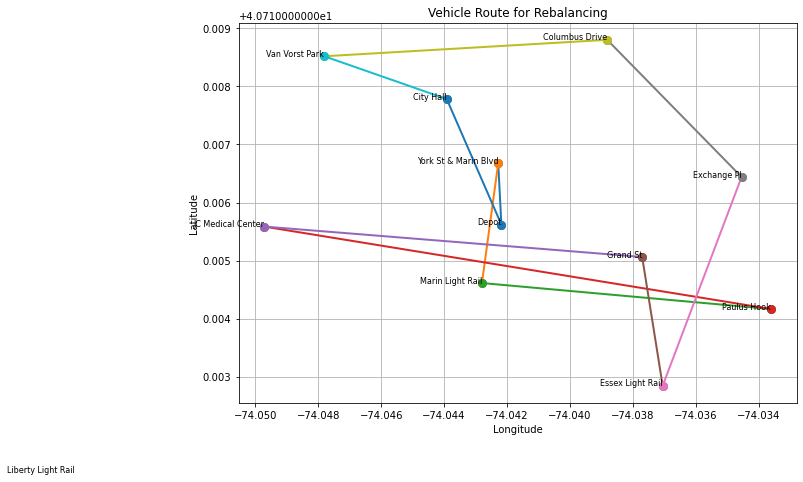

[(0, 4),
 (4, 8),
 (8, 9),
 (9, 6),
 (6, 7),
 (7, 10),
 (10, 5),
 (5, 1),
 (1, 2),
 (2, 3),
 (3, 0)]

In [405]:
import matplotlib.pyplot as plt

# Assuming routes and df_nodes are defined as before
routes = route_list

# Start with the initial node known, say from your route start
start_node = 0

# Reorder routes to maintain continuity
sorted_routes = []
current_node = start_node

# Dictionary to quickly find next node from a given node
route_dict = {start: end for start, end in routes}

# Continue looping until the route is complete
while route_dict:
    next_node = route_dict.pop(current_node)
    sorted_routes.append((current_node, next_node))
    current_node = next_node

# Extract coordinates in the correct order
route_coords = []
for start, end in sorted_routes:
    start_coords = (df_nodes.at[start, 'Longitude'], df_nodes.at[start, 'Latitude'])
    end_coords = (df_nodes.at[end, 'Longitude'], df_nodes.at[end, 'Latitude'])
    route_coords.append((start_coords, end_coords))

# Plotting
plt.figure(figsize=(10, 7))
for (lon, lat), (end_lon, end_lat) in route_coords:
    plt.plot([lon, end_lon], [lat, end_lat], 'o-', markersize=8, linewidth=2)  # Plot lines and nodes

# Annotate each point with the station name
for index, row in df_nodes.iterrows():
    plt.text(row['Longitude'], row['Latitude'], row['Station Name'], fontsize=8, ha='right')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Vehicle Route for Rebalancing')
plt.grid(True)
plt.savefig('Cluster_1/results_cluster1/results_optimization.png')
plt.show()
sorted_routes

In [406]:
station_name_series = df_nodes['Station Name']
parameters_df.insert(0, 'Station Name', station_name_series)

In [407]:
route_list=[]
if prob.status == GRB.OPTIMAL:
    for i in range(n):
        for j in range(n):
            if(x[i, j].X>0):
                route_list.append((i, j)) 
                print(f"Value of c[{i}]:", c[i].X)

Value of c[0]: 33.0
Value of c[1]: 12.0
Value of c[2]: 9.0
Value of c[3]: 5.0
Value of c[4]: 33.0
Value of c[5]: 13.0
Value of c[6]: 30.0
Value of c[7]: 25.0
Value of c[8]: 30.0
Value of c[9]: 31.0
Value of c[10]: 20.0


In [408]:
parameters_df

,Station Name,Capacity,Ideal Level,Existing_bikes,Demand,Surplus_station,Shortage_station
0,Depot,0,"[0, 0]",0,0,0,0
1,Columbus Drive,15,"[13, 13]",10,-3,0,1
2,Van Vorst Park,15,"[13, 13]",9,-4,0,1
3,City Hall,15,"[13, 13]",10,-3,0,1
4,York St & Marin Blvd,15,"[13, 13]",10,-3,0,1
5,Exchange Pl,15,"[13, 13]",12,-1,0,1
6,JC Medical Center,15,"[13, 13]",8,-5,0,1
7,Grand St,15,"[13, 13]",8,-5,0,1
8,Marin Light Rail,15,"[13, 13]",14,1,1,0
9,Paulus Hook,15,"[13, 13]",12,-1,0,1


In [409]:
parameters_df[['Station Name', 'Demand']]

,Station Name,Demand
0,Depot,0
1,Columbus Drive,-3
2,Van Vorst Park,-4
3,City Hall,-3
4,York St & Marin Blvd,-3
5,Exchange Pl,-1
6,JC Medical Center,-5
7,Grand St,-5
8,Marin Light Rail,1
9,Paulus Hook,-1


In [410]:
print('Operation and carbon cost: ' + str(round(obj.getValue(),2)))
print('The vehicle travelled {} stations and rebalanced {} bikes (picked up {} bikes and dropped off {} bikes).'.format(V.x, B.x, p_sum.x, d_sum.x))

Operation and carbon cost: 29.3
The vehicle travelled 11.0 stations and rebalanced 33.0 bikes (picked up 1.0 bikes and dropped off 32.0 bikes).


In [411]:
parameters_df.to_csv('Cluster_1/results_cluster1/parameters_fdf.csv', index=False)